In [1]:
import os
import glob
import ast
import json
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt

def load_from_pickle(filepath):
    """Load json_tempodata from a Pickle (.pkl) file."""
    # filepath = os.path.join(readpath, filename)
    with open(filepath, "rb") as f:
        json_tempodata = pickle.load(f)
    return json_tempodata

#### Load files

In [ ]:
a = 60
b = 140
mode = "zero_uni"

bpm_dict = {"bpm_avg": 0,  "bpm_mode": 1, "bpm_median": 2}

pos_hits_stats = load_from_pickle(f"./one_sensor/tempo_60_140/pos/hit_stats_{mode}_{a}_{b}.pkl")
pos_hits_stats_genrewise = load_from_pickle(f"./one_sensor/tempo_60_140/pos/hit_stats_genrewise_{mode}_{a}_{b}.pkl")      # hits summary genre wise          

vel_hits_stats = load_from_pickle(f"./one_sensor/tempo_60_140/vel/hit_stats_{mode}_{a}_{b}.pkl")
vel_hits_stats_genrewise = load_from_pickle(f"./one_sensor/tempo_60_140/vel/hit_stats_genrewise_{mode}_{a}_{b}.pkl")      # hits summary genre wise                   

##### Extract hits from velocity data ######
union_hits_y = pos_hits_stats["bpm_median"]["final_hits_y"]["union_hits"]      # total hits including both the hands and foots

pos_hand_y = set(pos_hits_stats["bpm_median"]["estimated_bpm"]["both_hand_y"].keys())
pos_foot_y = set(pos_hits_stats["bpm_median"]["estimated_bpm"]["both_foot_y"].keys())

vel_hand_y = set(vel_hits_stats["bpm_median"]["estimated_bpm"]["both_hand_y"].keys())
vel_foot_y = set(vel_hits_stats["bpm_median"]["estimated_bpm"]["both_foot_y"].keys())

vel_hand_y_hits = vel_hand_y - pos_hand_y   # hits not detected by position
vel_foot_y_hits = vel_foot_y - pos_foot_y   # hits not detected by position

In [ ]:


print("pos_hand_y:", len(pos_hand_y))
print("pos_foot_y:", len(pos_foot_y))
print("vel_hand_y:", len(vel_hand_y))
print("vel_foot_y:", len(vel_foot_y))

pos_hand_y: 725
pos_foot_y: 735
vel_hand_y: 726
vel_foot_y: 697


In [20]:
vel_hand_no_duplicate = vel_hand_y - pos_hand_y
vel_foot_no_duplicate = vel_foot_y - pos_foot_y

print("vel hand hits:", len(vel_hand_no_duplicate))
print("vel foot hits:", len(vel_foot_no_duplicate))

vel hand hits: 161
vel foot hits: 164


#### Tempo Estimation Accuracy per Body Segment by Metric

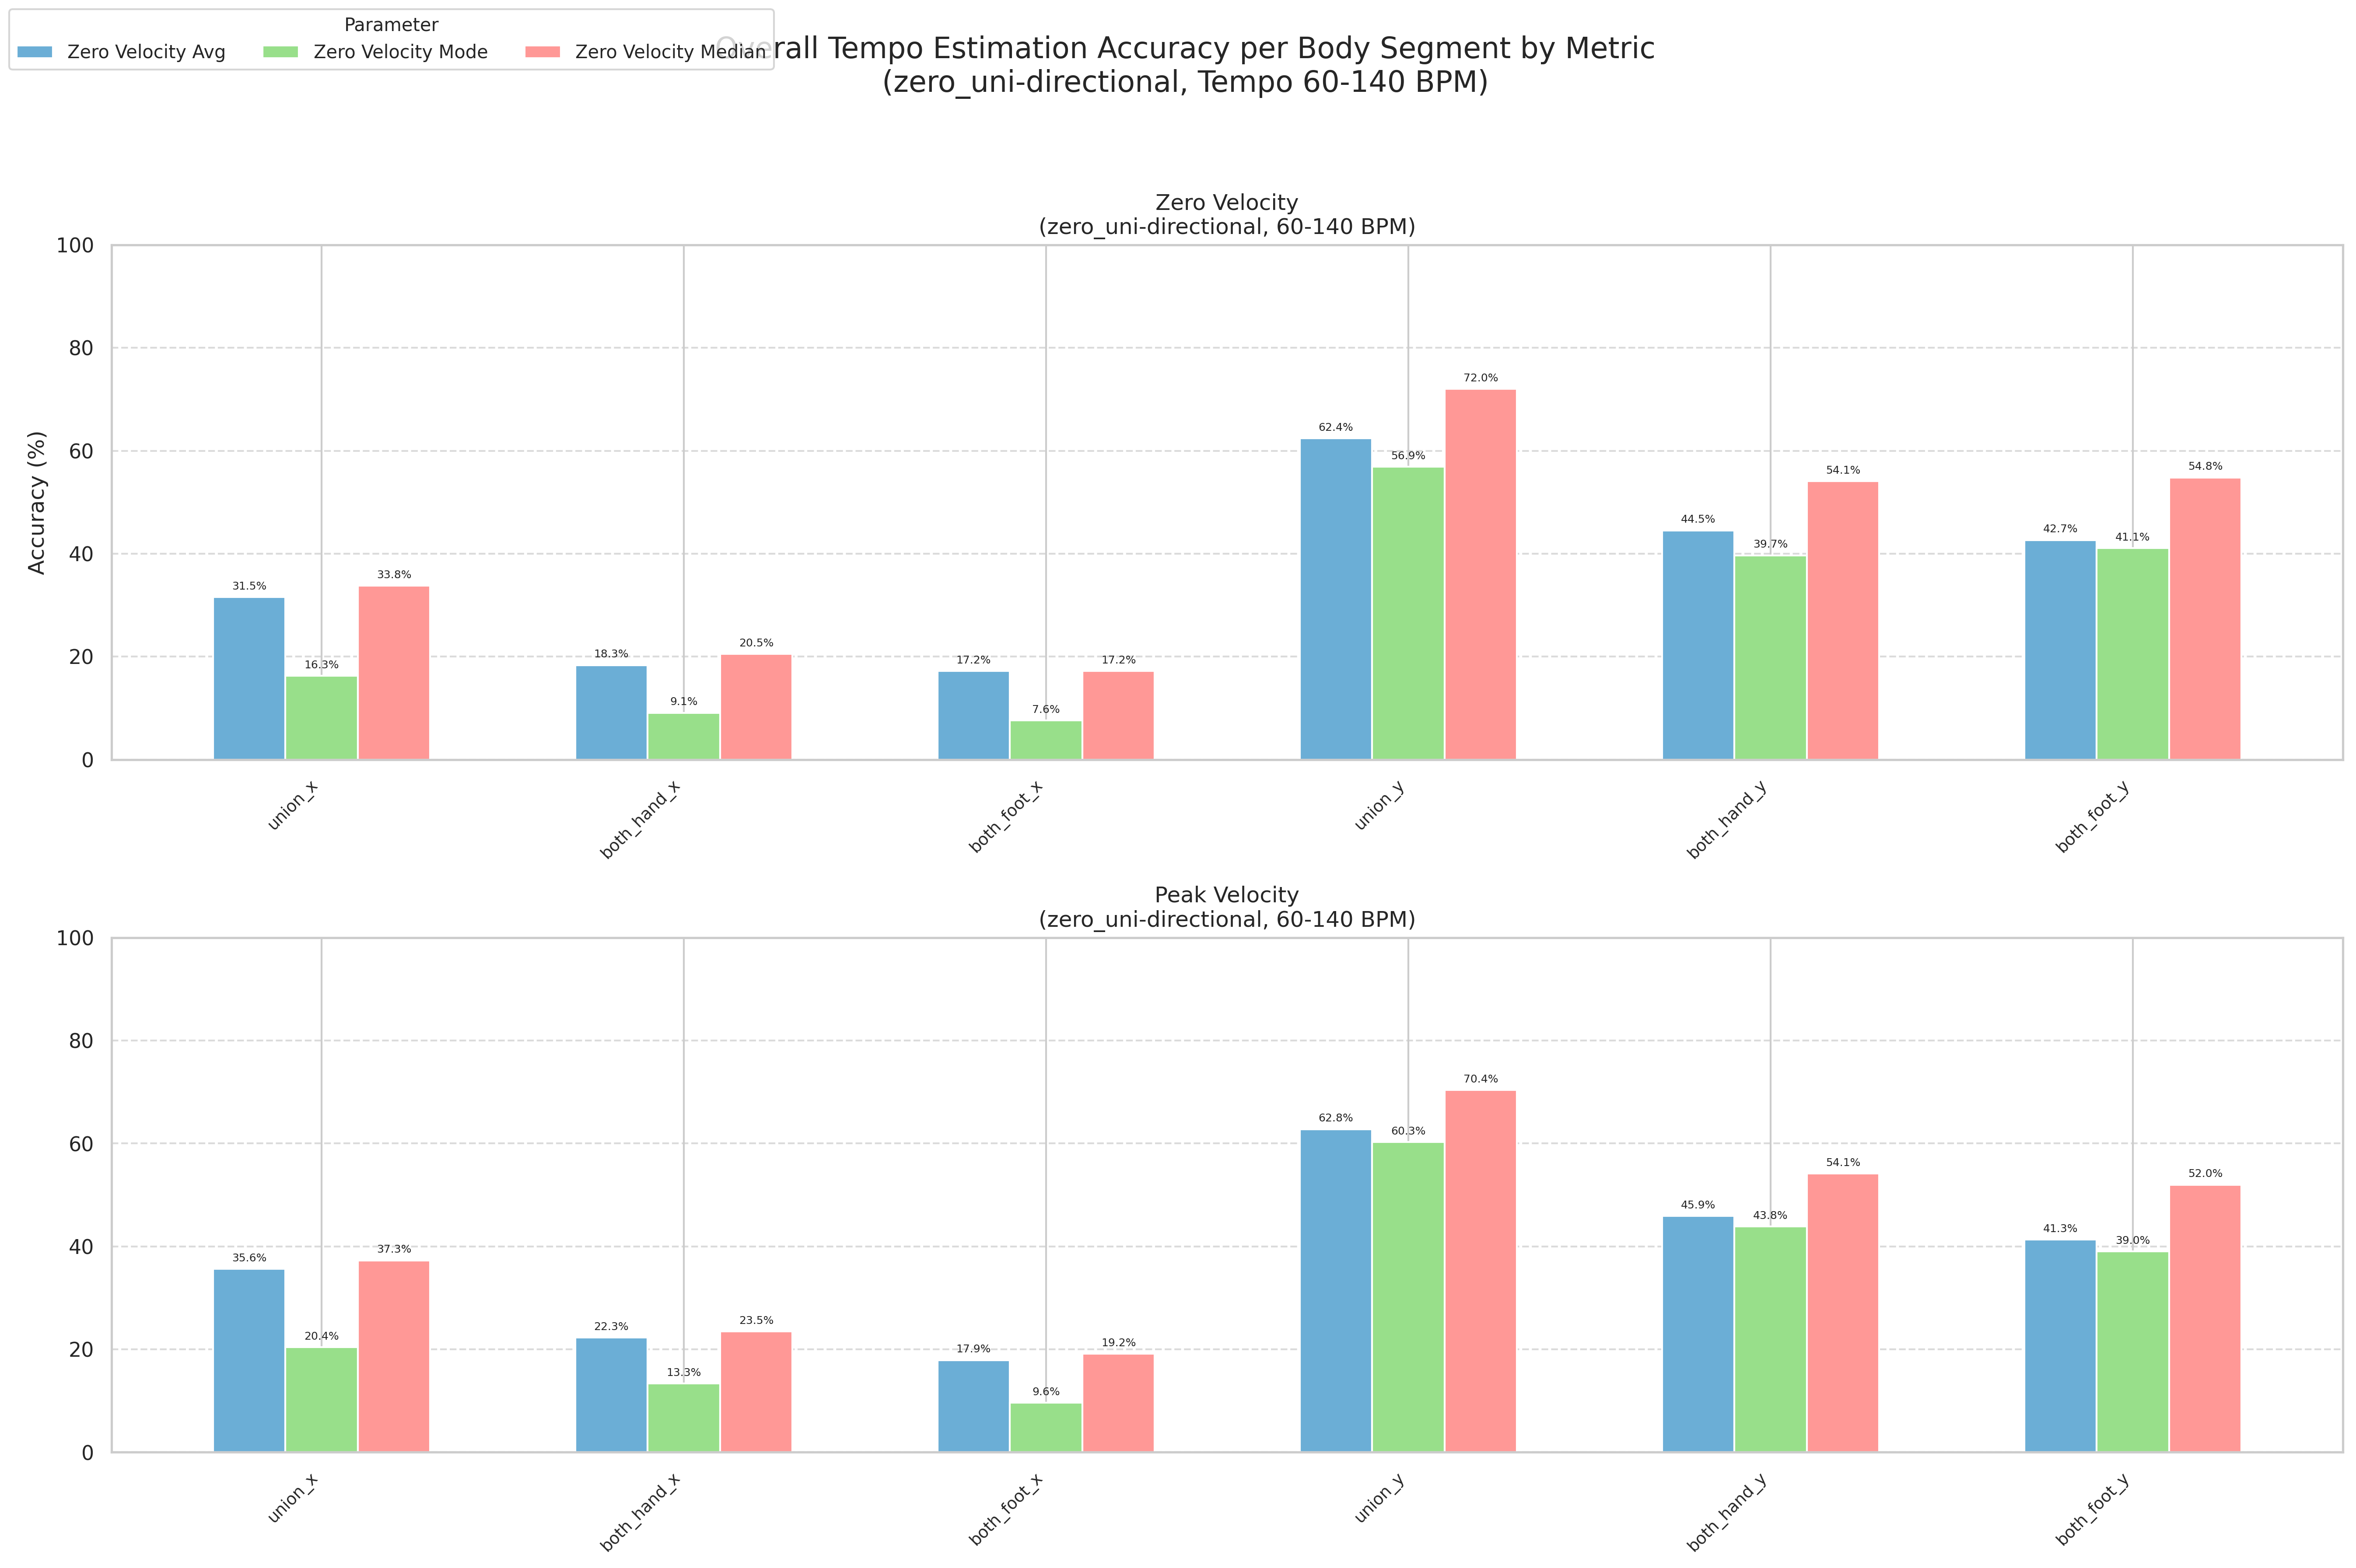

In [32]:

width = 0.2  # Bar width for grouped bars
# Define the categories from the updated hits_percentage structure.
categories = ["union_x", "both_hand_x", "both_foot_x", "union_y", "both_hand_y", "both_foot_y"]
x = np.arange(len(categories))

# Colors for each metric category
avg_color = "#6baed6"
mode_color = "#98df8a"
median_color = "#ff9896"

# Titles/labels for the two hit_stats dictionaries
labl = {"Zero Velocity": "Zero Velocity", "Peak Velocity": "Peak Velocity"}
hit_stats_list = {"Zero Velocity": pos_hits_stats, "Peak Velocity": vel_hits_stats}

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharey=True, dpi=300)

for ax, (title, current_hit_stats) in zip(axes, hit_stats_list.items()):
    # Extract values for each metric and category
    avg_vals = [current_hit_stats['bpm_avg']['hits_percentage'][cat] for cat in categories]
    mode_vals = [current_hit_stats['bpm_mode']['hits_percentage'][cat] for cat in categories]
    median_vals = [current_hit_stats['bpm_median']['hits_percentage'][cat] for cat in categories]
    
    # Plot grouped bars for each metric
    bars_avg = ax.bar(x - width, avg_vals, width, label=f'{labl[title]} Avg', color=avg_color)
    bars_mode = ax.bar(x, mode_vals, width, label=f'{labl[title]} Mode', color=mode_color)
    bars_median = ax.bar(x + width, median_vals, width, label=f'{labl[title]} Median', color=median_color)
    
    # Add percentage labels on the bars
    for bars in [bars_avg, bars_mode, bars_median]:
        ax.bar_label(bars, fmt='%.1f%%', padding=3, fontsize=6)
    
    ax.set_title(f'{title}\n({mode}-directional, {a}-{b} BPM)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[0].set_ylabel('Accuracy (%)', fontsize=12)

# Create a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Parameter", fontsize=10, title_fontsize=10, loc='upper left', ncol=3)

plt.suptitle(f'Overall Tempo Estimation Accuracy per Body Segment by Metric\n({mode}-directional, Tempo {a}-{b} BPM)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Tempo Estimation Accuracy by Genre

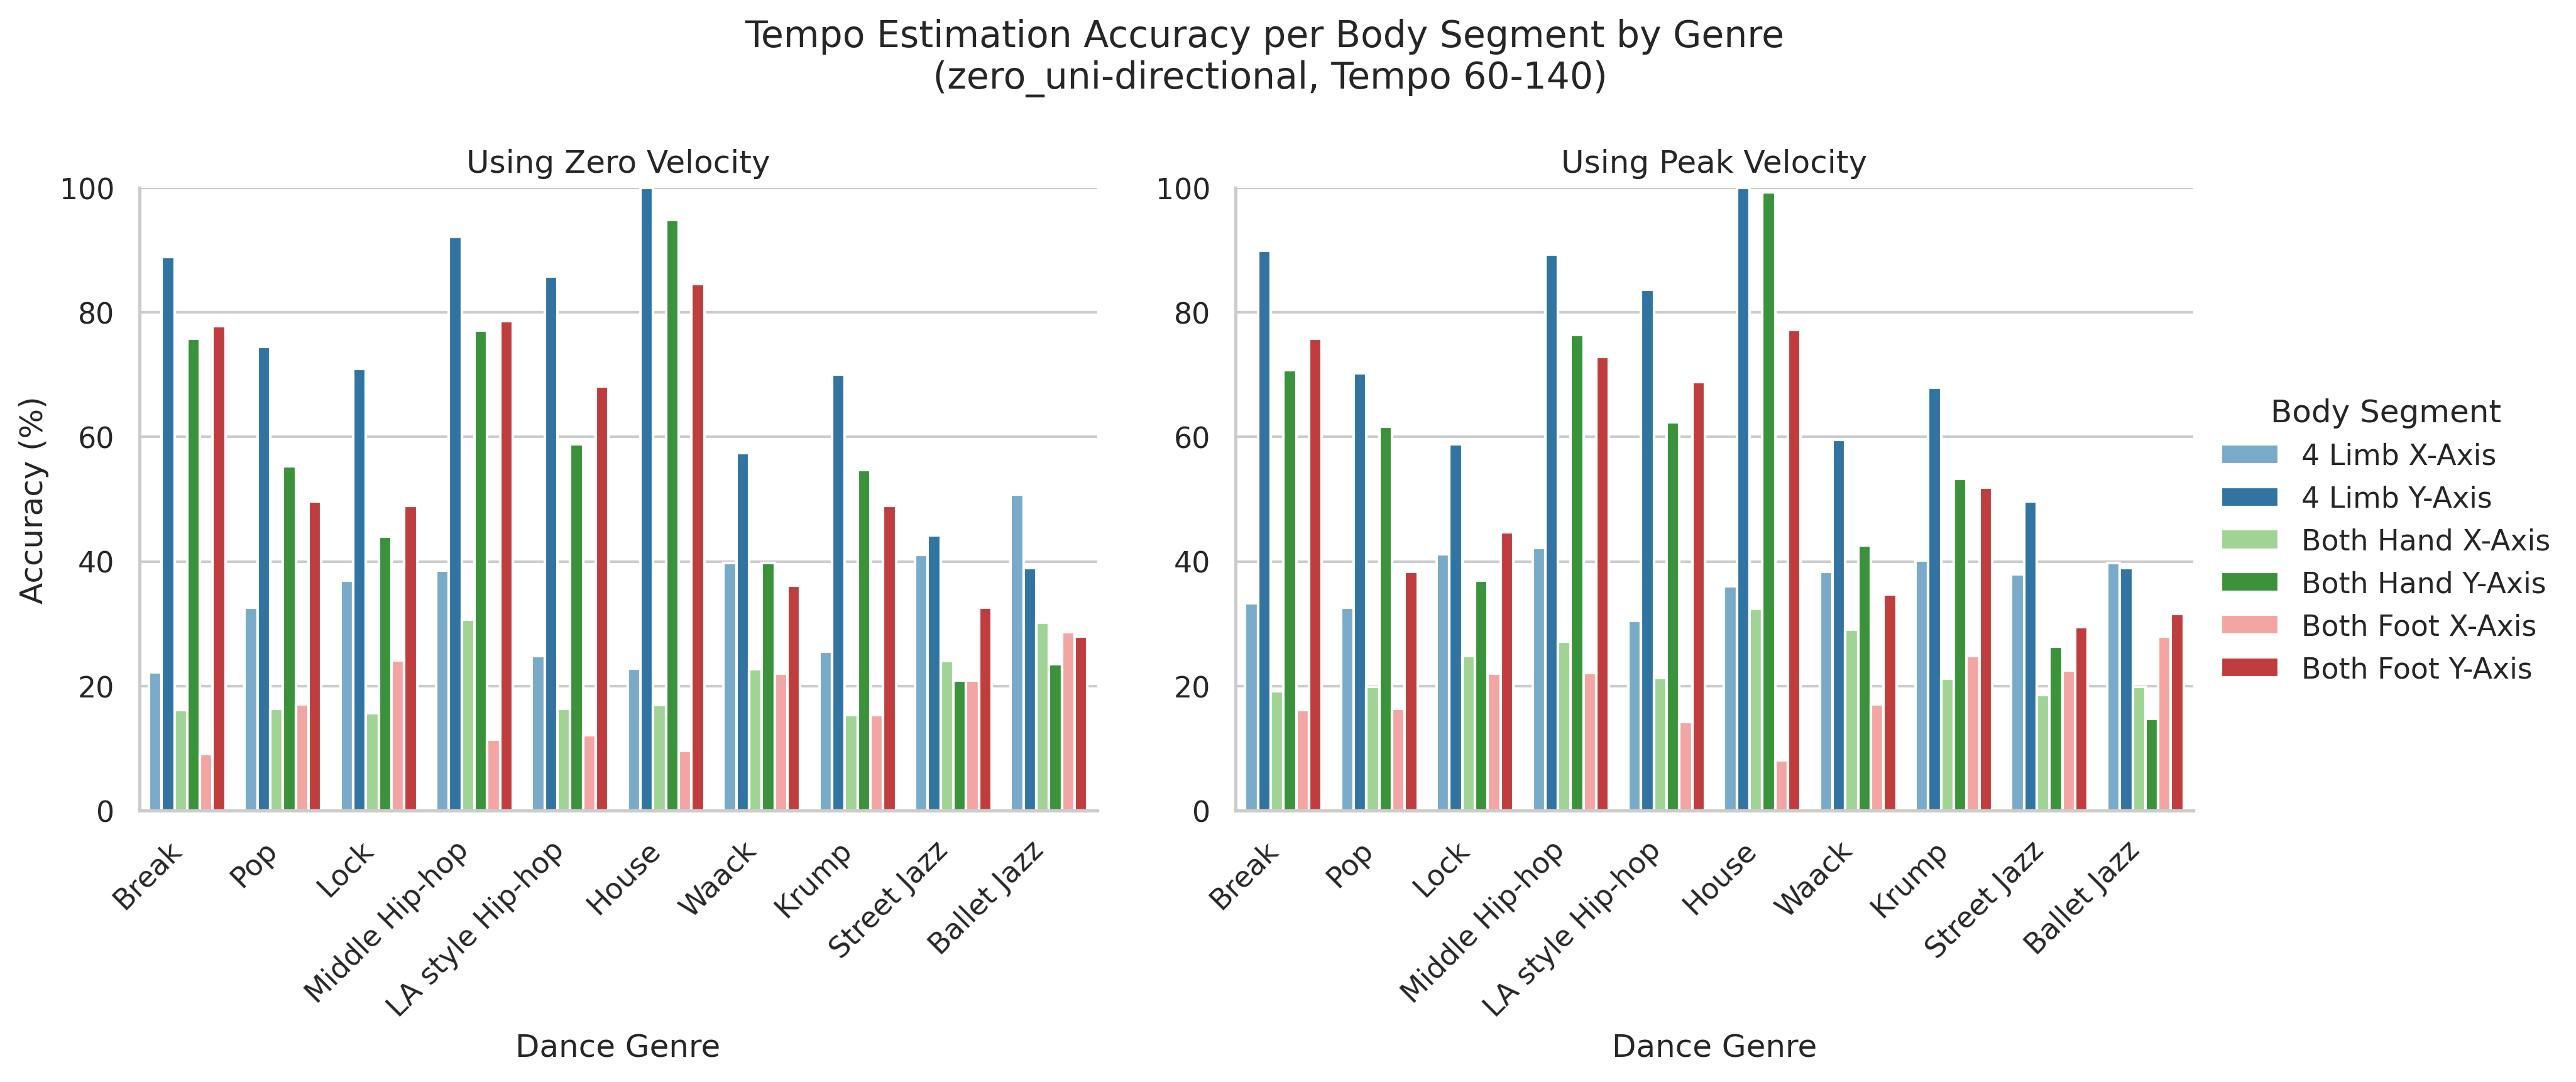

In [34]:
def melt_df(df, metric_label):
    melted = df.melt(
        id_vars=["genre"],
        value_vars=['union_x_percentage', 'union_y_percentage', 'both_hand_x_percentage', 'both_hand_y_percentage',
                    'both_foot_x_percentage', 'both_foot_y_percentage'],
        var_name="Segment",
        value_name="Accuracy"
    )
    # Mapping for cleaner labels
    segment_map = {
        "union_x_percentage": "4 Limb X-Axis",
        "union_y_percentage": "4 Limb Y-Axis",
        "both_hand_x_percentage": "Both Hand X-Axis",
        "both_hand_y_percentage": "Both Hand Y-Axis",
        "both_foot_x_percentage": "Both Foot X-Axis",
        "both_foot_y_percentage": "Both Foot Y-Axis",
    }
    melted["Segment"] = melted["Segment"].map(segment_map)
    melted["Metric"] = metric_label
    return melted


# Combine all metrics
pos_melt = melt_df(pos_hits_stats_genrewise['bpm_median'], "Using Zero Velocity")
vel_melt = melt_df(vel_hits_stats_genrewise['bpm_median'], "Using Peak Velocity")
# posvel_melt = melt_df(posvel_hits_stats_genrewise['bpm_median_xy'], "PosVel Median XY")

combined_df = pd.concat([pos_melt, vel_melt])

palette = {
    "4 Limb X-Axis": "#6baed6",      # Light Blue
    "4 Limb Y-Axis": "#1f77b4",      # Dark Blue
    "Both Hand X-Axis": "#98df8a",   # Light Green
    "Both Hand Y-Axis": "#2ca02c",   # Dark Green
    "Both Foot X-Axis": "#ff9896",   # Light Red
    "Both Foot Y-Axis": "#d62728",   # Dark Red
}


# Faceted grouped vertical bar chart
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=combined_df,
    kind="bar",
    x="genre", y="Accuracy", hue="Segment",
    col="Metric",
    palette=palette,
    height=5, aspect=1.2,
    legend_out=True,
    sharey=False,
)

g.figure.set_dpi(300)
g.set_axis_labels("Dance Genre", "Accuracy (%)")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45, ha='right')
g.set(ylim=(0, 100))
g._legend.set_title("Body Segment")

# Add percentage labels on top of bars
# for ax in g.axes.flat:
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

plt.subplots_adjust(top=0.80)
g.figure.suptitle(f"Tempo Estimation Accuracy per Body Segment by Genre\n ({mode}-directional, Tempo {a}-{b})", fontsize=14)
plt.show()

#### BoxPlot: Tempo Accuracy Distributions Across Dance

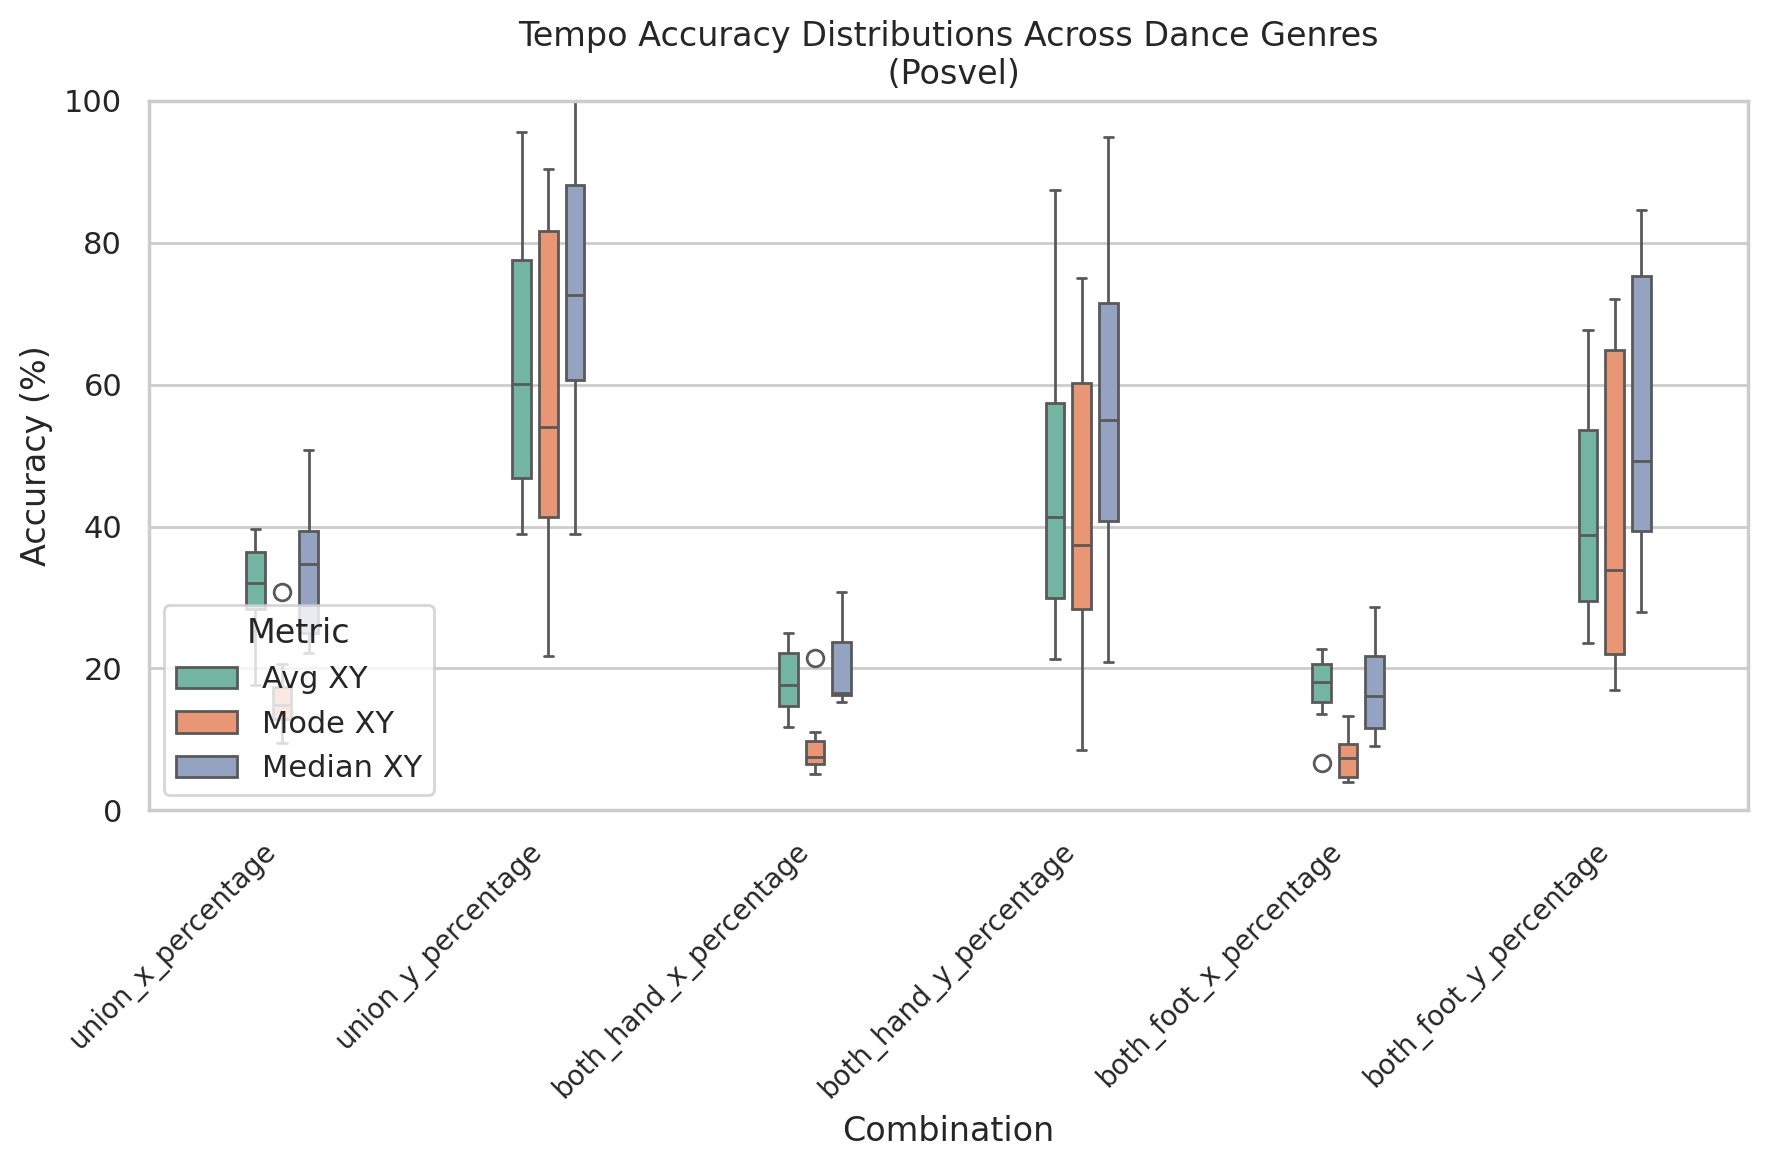

In [29]:
combination = [
    'union_x_percentage', 'union_y_percentage', 'both_hand_x_percentage', 'both_hand_y_percentage',
    'both_foot_x_percentage', 'both_foot_y_percentage'
]

# Melt each dataframe for long-form representation
avg_xy = pos_hits_stats_genrewise["bpm_avg"].melt(
    id_vars=["genre"], value_vars=combination,
    var_name="Type", value_name="Consistency (%)"
)
avg_xy["Consistency Type"] = "Avg XY"

avg_mode = pos_hits_stats_genrewise["bpm_mode"].melt(
    id_vars=["genre"], value_vars=combination,
    var_name="Type", value_name="Consistency (%)"
)
avg_mode["Consistency Type"] = "Mode XY"

avg_median = pos_hits_stats_genrewise["bpm_median"].melt(
    id_vars=["genre"], value_vars=combination,
    var_name="Type", value_name="Consistency (%)"
)
avg_median["Consistency Type"] = "Median XY"

# Combine all long-form dataframes
combined_long = pd.concat([avg_xy, avg_mode, avg_median])

# Create the grouped boxplot
plt.figure(figsize=(9, 6), dpi=200)
sns.boxplot(
    data=combined_long,
    x="Type",
    y="Consistency (%)",
    hue="Consistency Type",  # Grouping by Consistency Type
    palette="Set2",
    width=0.3,
    gap=0.3,
    # fill=False,
    linewidth=1
)

# Plot aesthetics
plt.title(f"Tempo Accuracy Distributions Across Dance Genres\n (Posvel)")
plt.xlabel("Combination")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 100)
plt.legend(title="Metric", loc="lower left")
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
